# Lung Infection Detection

#### Ryan Butler 

This notebook trains deep-learning Convolutional Neural Networks to classify three different types of lung disease from x-ray images. <br>
0 == Healthy<br>
1 == Mild Disease<br>
2 == Severe Disease<br>



Import the necessary libraries

Plot the sample images for all the classes 

Plot the distribution of images across the classes

Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48

Build a data augmentation for test data to create new data and rescale the image at 48x48

Read images directly from the train folder and test folder using the appropriate function


Ideas: <br>
* Possibly look for pretrained x-ray
* Imagenet imitation
* Possibly dive into papers to improve
* Semantic Scholar.org find the OG paper and cite, look for what other cited papers are doing to it
    * See data augmentation methods
* https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full
* ConvNeXt
    * https://github.com/facebookresearch/ConvNeXt
    * Maybe take the small one
* See about ResNet
* Research to see about freezing the BatchNormalization() later (this usually causes problems)
* Jax framework
* Pytorch and Tensorflow are the go to learn (Jax is sort of an offshoot)

### Importing Libraries

In [1]:
import tensorflow as tf
tf.__version__

2023-12-02 10:00:47.693224: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 10:00:47.859217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 10:00:47.859278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 10:00:47.860212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 10:00:47.951694: I tensorflow/core/platform/cpu_feature_g

'2.14.0'

In [2]:
from tensorflow import keras
import keras.utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Run this cell if GPU is available

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2023-12-02 10:00:50.016553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 10:00:50.027285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 10:00:50.027365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Load Data + Plot Sample Images 

In [4]:
from tensorflow.keras.utils import load_img

sample = load_img('data/train/healthy/01.jpeg')
#  sample.show()

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                'data/train')
test_data = image_dataset_from_directory('data/test')

Found 251 files belonging to 3 classes.


2023-12-02 10:00:50.126816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 10:00:50.127236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 10:00:50.127466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 66 files belonging to 3 classes.


In [6]:
data_iterator = train_data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

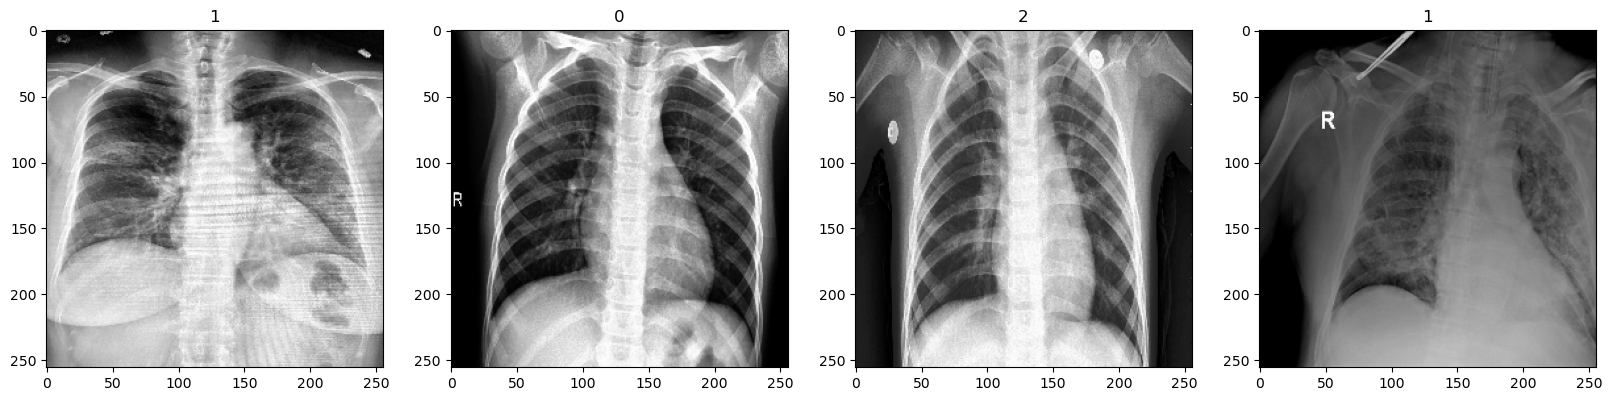

In [8]:
# Visualize the training data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
image_size = (48, 48)
batch_size = 10

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


### Plot Distribution of Images Across Classes

In [10]:
# Get count of how many files are in each directory

import os, os.path

file_names = ['healthy', 'type 1 disease', 'type 2 disease']

def get_file_count(path, name):
    file_dict = {}

    for x in name:
        for name in os.listdir(f'{path}{x}'):
            file_dict[x] = file_dict.get(x,0)+1
            
    return file_dict

train_data_bar = get_file_count('data/train/',file_names)
test_data_bar = get_file_count('data/test/',file_names)

In [11]:
print(train_data_bar)
print(test_data_bar)

{'healthy': 70, 'type 1 disease': 111, 'type 2 disease': 70}
{'healthy': 20, 'type 1 disease': 26, 'type 2 disease': 20}


<Axes: >

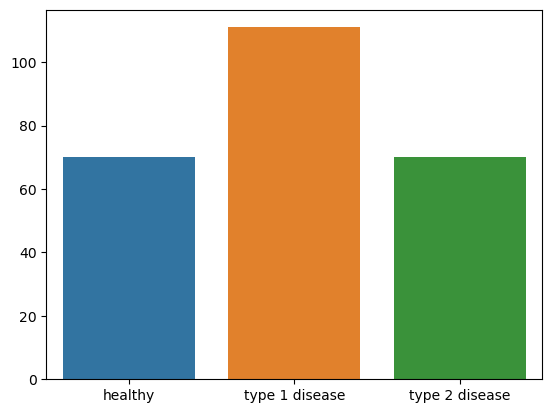

In [12]:
# Get distribution of training data
keys = list(train_data_bar.keys())
vals = [value for value in train_data_bar.values()]
sns.barplot(x=keys, y=vals)

<Axes: >

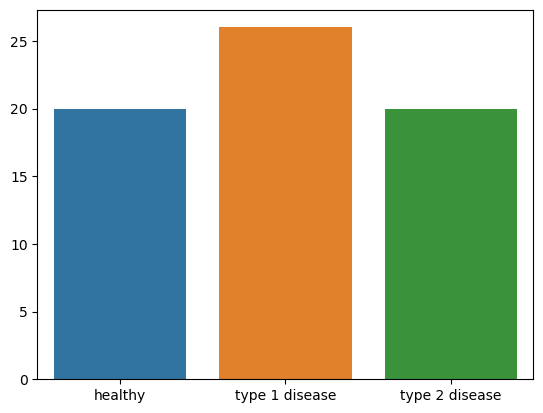

In [13]:
# Get distribution of test data
keys = list(test_data_bar.keys())
vals = [value for value in test_data_bar.values()]
sns.barplot(x=keys, y=vals)

### Data Augmentation for Training Data

In [14]:
from keras.models import Sequential
from keras import layers

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


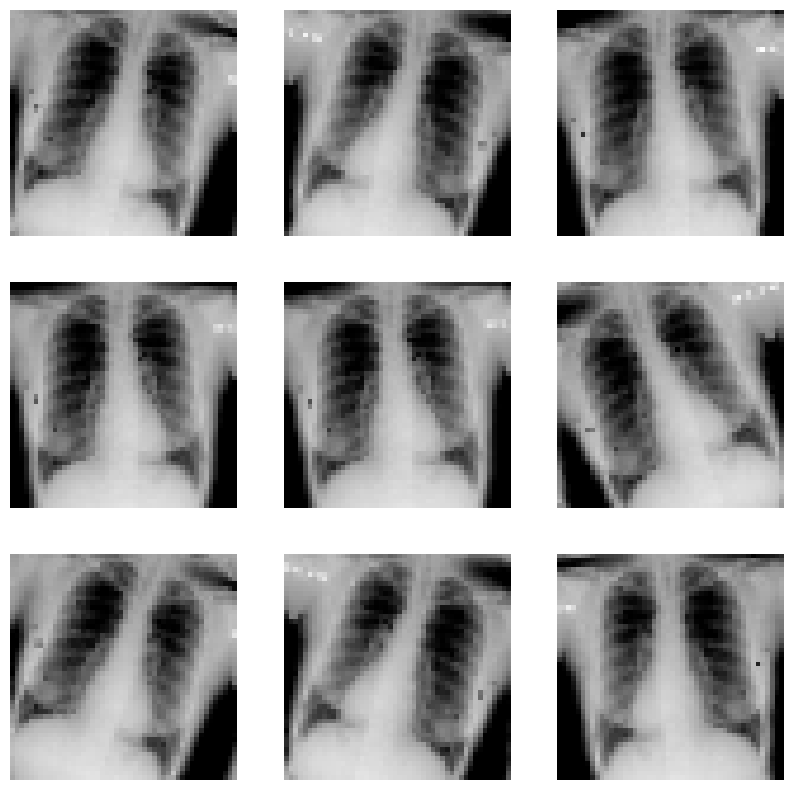

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Data Preprocessing

Apply this function within the model training phase

In [16]:
def image_augmentation(training_data):
    augmented_train_ds = training_data.map(
        lambda x, y: (data_augmentation(x, training=True), y))
    return augmented_train_ds

### Building the Model



Add convolutional layers with different filters, max pool layers, dropout layers, and batch normalization layers  

Use Relu as an activation function

Take the loss function as categorical cross-entropy

Take rmsprop as an optimizer

Use early stopping with the patience of two epochs and monitor the validation loss or accuracy

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good


In [17]:
# Model which gets over 97.5% on MNIST dataset (O'Reilly ML)
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

model = Sequential([
    Convolution2D(32, kernel_size=3, padding="same", activation="relu"),
    Convolution2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")])

### Train Model

In [18]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision
epochs = 50

# callbacks = [
#     keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# ]
model.compile(
    optimizer= RMSprop(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_cnn = model.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    # callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50


2023-12-02 10:00:52.884459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-02 10:00:53.448451: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f17ea2a7d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 10:00:53.448467: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-02 10:00:53.451970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-02 10:00:53.494469: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 2s 19ms/step - loss: 1289.4280 - accuracy: 0.3582 - val_loss: 1.2734 - val_accuracy: 0.4800
Epoch 2/50
21/21 [==============================] - 0s 14ms/step - loss: 1.4011 - accuracy: 0.4925 - val_loss: 1.1823 - val_accuracy: 0.4400
Epoch 3/50
21/21 [==============================] - 0s 14ms/step - loss: 1.3691 - accuracy: 0.4975 - val_loss: 0.9610 - val_accuracy: 0.5000
Epoch 4/50
21/21 [==============================] - 0s 13ms/step - loss: 12.2861 - accuracy: 0.4577 - val_loss: 0.8793 - val_accuracy: 0.6200
Epoch 5/50
21/21 [==============================] - 0s 13ms/step - loss: 3.8989 - accuracy: 0.5323 - val_loss: 0.9459 - val_accuracy: 0.5600
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 9.2584 - accuracy: 0.5274 - val_loss: 0.8899 - val_accuracy: 0.5800
Epoch 7/50
21/21 [==============================] - 0s 12ms/step - loss: 1.3767 - accuracy: 0.5224 - val_loss: 0.8428 - val_accuracy: 0.6400
Epoch 8/50
21/21 [==

In [19]:
# model.summary()

### Plotting Accuracy/Loss

In [20]:
# Plotting our loss charts
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, x, x_loss, label1, label2):
    # Use the History object we created to get our saved performance results
    history_dict = history.history

    # Extract the loss and validation losses
    loss_values = history_dict[x]
    val_loss_values = history_dict[x_loss]

    # Get the number of epochs and create an array up to that number using range()
    epochs = range(1, len(loss_values) + 1)

    # Plot line charts for both Validation and Training Loss
    line1 = plt.plot(epochs, val_loss_values, label=label1)
    line2 = plt.plot(epochs, loss_values, label=label2)
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel(x)
    plt.grid(True)
    plt.legend()
    plt.show()

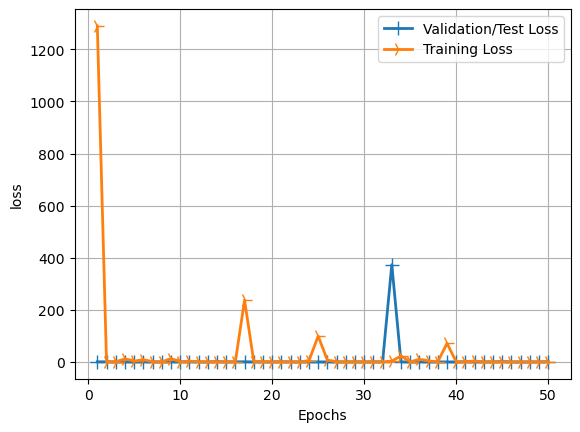

In [21]:
plot_accuracy_loss(history_cnn, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

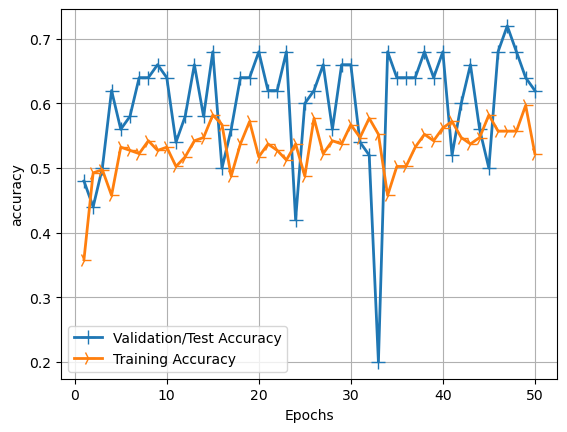

In [22]:
plot_accuracy_loss(history_cnn, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

In [23]:
# get_ac = history_cnn.history['accuracy']
# get_los = history_cnn.history['loss']
# val_acc = history_cnn.history['val_accuracy']
# val_loss = history_cnn.history['val_loss']

In [24]:
# epochs = range(len(get_ac))
# plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
# plt.plot(epochs, get_los, 'r', label='Loss of Training data')
# plt.title('Training data accuracy and loss')
# plt.legend(loc=0)
# plt.figure()

# plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
# plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
# plt.title('Training and Validation Accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
# plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
# plt.title('Training and Validation Loss')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

## Another CNN to Test Out

This CNN performed really well on MRI Brain data, curious to see how it performs here

In [25]:
# MRI CNN
model_mri = keras.models.Sequential()
model_mri.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(48, 48, 3)))
model_mri.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_mri.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model_mri.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_mri.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_mri.add(keras.layers.Dropout(0.20))

model_mri.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_mri.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_mri.add(keras.layers.Dropout(0.25))
model_mri.add(keras.layers.Flatten())
model_mri.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model_mri.add(keras.layers.Dense(64,"relu"))
model_mri.add(keras.layers.Dense(4,"softmax"))

In [26]:
model_mri.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [27]:
model_mri.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 32)       

In [28]:
hist_cnn_mri= model_mri.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50


2023-12-02 10:01:16.522876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 2s 20ms/step - loss: 1.1953 - accuracy: 0.4975 - val_loss: 1.0920 - val_accuracy: 0.3400
Epoch 2/50
21/21 [==============================] - 0s 15ms/step - loss: 0.8470 - accuracy: 0.5771 - val_loss: 0.5278 - val_accuracy: 0.8200
Epoch 3/50
21/21 [==============================] - 0s 13ms/step - loss: 0.5096 - accuracy: 0.7910 - val_loss: 0.3555 - val_accuracy: 0.9000
Epoch 4/50
21/21 [==============================] - 0s 13ms/step - loss: 0.3444 - accuracy: 0.8756 - val_loss: 0.3247 - val_accuracy: 0.8800
Epoch 5/50
21/21 [==============================] - 0s 12ms/step - loss: 0.3450 - accuracy: 0.8657 - val_loss: 0.3509 - val_accuracy: 0.8200
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 0.4371 - accuracy: 0.8159 - val_loss: 0.3325 - val_accuracy: 0.8600
Epoch 7/50
21/21 [==============================] - 0s 12ms/step - loss: 0.2906 - accuracy: 0.9005 - val_loss: 0.2359 - val_accuracy: 0.9000
Epoch 8/50
21/21 [======

In [29]:
get_ac = hist_cnn_mri.history['accuracy']
get_los = hist_cnn_mri.history['loss']
val_acc = hist_cnn_mri.history['val_accuracy']
val_loss = hist_cnn_mri.history['val_loss']

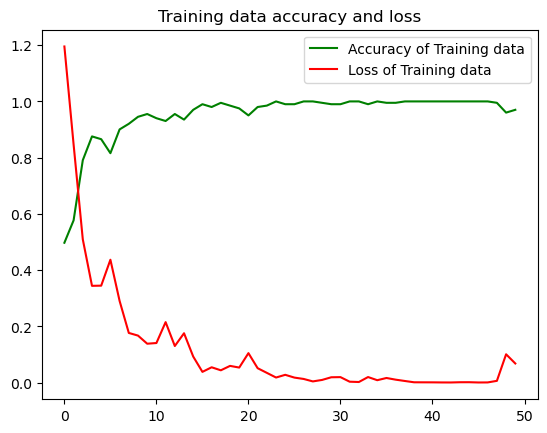

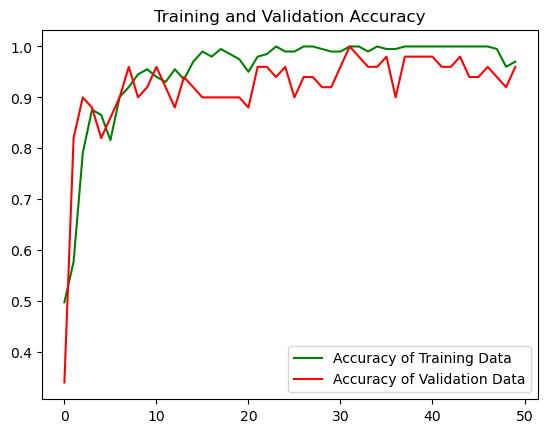

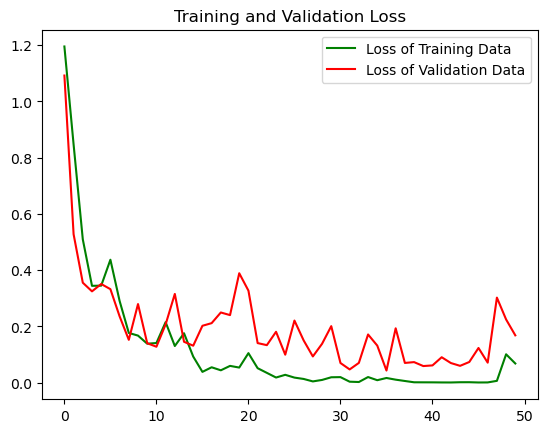

<Figure size 640x480 with 0 Axes>

In [30]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

### Transfer Learning (Mobile Net)



Prepare data for the pre-trained mobile net model, with color mode as RGB

Create an instance of a mobile net pre-trained model 

Add dense layer, dropout layer, batch normalization layer on the pre-trained model

Create a final output layer with a SoftMax activation function

Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases

Take the loss function as categorical cross-entropy

Use early stopping with the patience of two epoch and call back function for preventing overfitting

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

 Plot the training and validation accuracy, and the loss

 Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good


In [31]:
mobile = keras.applications.mobilenet.MobileNet(classifier_activation='softmax')

In [32]:
# mobile.summary()

#### Color Model

In [33]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=10,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [34]:
# Making the model
mobile_model_rgb_1 = Sequential([
    mobile,
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation="softmax")
                          ])

In [35]:
from tensorflow.keras.optimizers import Adam
# Train Mobile Model
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
mobile_model_rgb_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_mobile = mobile_model_rgb_1.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 6s 39ms/step - loss: 1.0661 - accuracy: 0.3682 - val_loss: 1.0957 - val_accuracy: 0.3600
Epoch 2/10
21/21 [==============================] - 1s 30ms/step - loss: 0.9286 - accuracy: 0.5871 - val_loss: 1.0852 - val_accuracy: 0.6000
Epoch 3/10
21/21 [==============================] - 1s 28ms/step - loss: 0.7750 - accuracy: 0.7214 - val_loss: 1.0712 - val_accuracy: 0.7200
Epoch 4/10
21/21 [==============================] - 1s 27ms/step - loss: 0.7023 - accuracy: 0.7463 - val_loss: 1.0529 - val_accuracy: 0.8400
Epoch 5/10
21/21 [==============================] - 1s 29ms/step - loss: 0.5687 - accuracy: 0.8159 - val_loss: 1.0265 - val_accuracy: 0.8600
Epoch 6/10
21/21 [==============================] - 1s 27ms/step - loss: 0.5594 - accuracy: 0.8259 - val_loss: 1.0165 - val_accuracy: 0.8200
Epoch 7/10
21/21 [==============================] - 1s 28ms/step - loss: 0.5109 - accuracy: 0.8607 - val_loss: 0.9891 - val_accuracy: 0.8000
Epoch 8/10
21

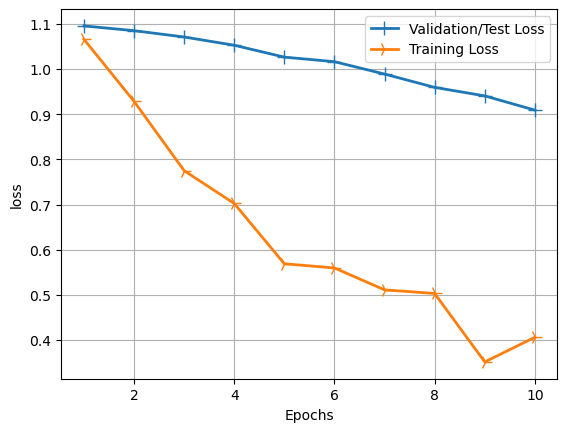

In [36]:
plot_accuracy_loss(history_mobile, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

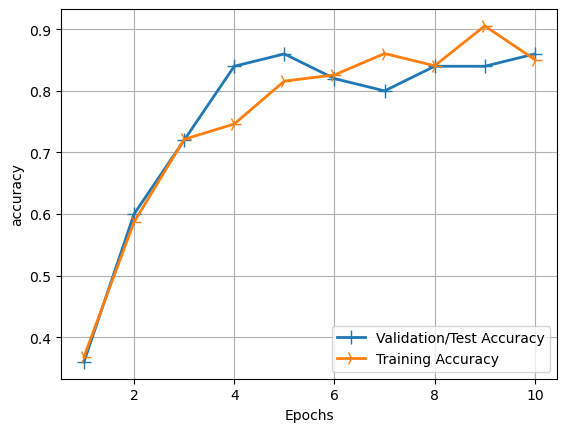

In [37]:
plot_accuracy_loss(history_mobile, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Chaging Batch Size and Optimizer

In [38]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=10,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [39]:
# Making the model
mobile_model_rgb_2 = Sequential([
    mobile,
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation="softmax")
                          ])

In [40]:
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
mobile_model_rgb_2.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_mobile = mobile_model_rgb_2.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 4s 37ms/step - loss: 1.0908 - accuracy: 0.4925 - val_loss: 1.0863 - val_accuracy: 0.4800
Epoch 2/10
21/21 [==============================] - 1s 28ms/step - loss: 0.9380 - accuracy: 0.5274 - val_loss: 1.0304 - val_accuracy: 0.5800
Epoch 3/10
21/21 [==============================] - 1s 27ms/step - loss: 0.7566 - accuracy: 0.6368 - val_loss: 1.0776 - val_accuracy: 0.4800
Epoch 4/10
21/21 [==============================] - 1s 29ms/step - loss: 1.0425 - accuracy: 0.5274 - val_loss: 1.0542 - val_accuracy: 0.4800


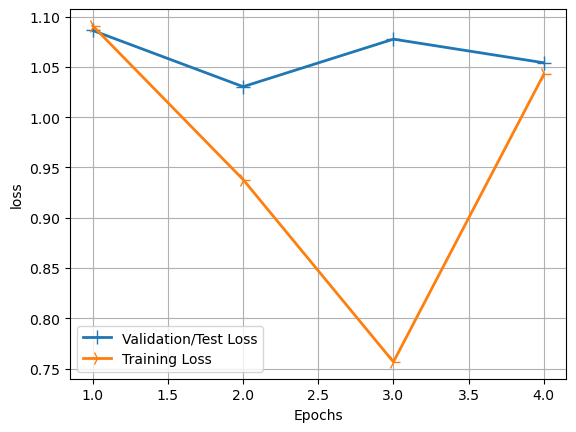

In [41]:
plot_accuracy_loss(history_mobile, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

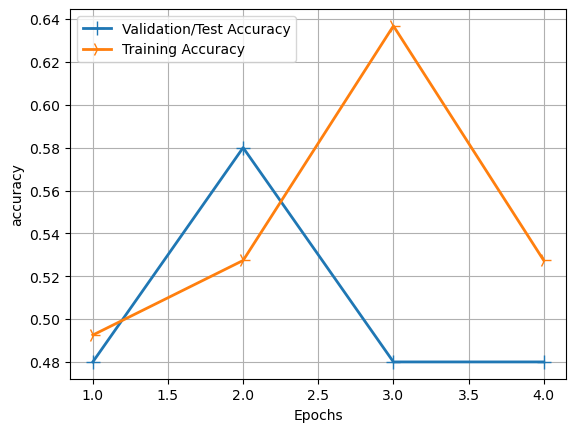

In [42]:
plot_accuracy_loss(history_mobile, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Greyscale Model

The pretrained model is trained on RGB pictures and cannot be applied to greyscale images

### Transfer Learning (Densenet121)



Prepare the dataset for the transfer learning algorithm using Densenet121 with the image size as 224x224x3

Freeze the top layers of the pre-trained model

Add a dense layer at the end of the pre-trained model followed by a dropout layer and try various combinations to get an accuracy

Add the final output layer with a SoftMax activation function

Take loss function as categorical cross-entropy

Take Adam as an optimizer

Use early stopping to prevent overfitting

Try with 15 number of epoch and batch size with seven, also try various values to see the impact on results

Train the model using the generator and test the accuracy of the test data at every epoch 

 Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good

In [43]:
dense_model = keras.applications.DenseNet121(classifier_activation='softmax')

In [44]:
# dense_model.summary()

Use the same datasets as above for training this model

Freeze Layers

In [45]:
dense_model.trainable = False

In [46]:
inputs = keras.Input(shape=(224,224, 3))
x = dense_model(inputs, training=False)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(3)(x)
dense_model_add = keras.Model(inputs, outputs)


In [47]:
# Train Dense Model
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
dense_model_add.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_dense = dense_model_add.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 4s 77ms/step - loss: 5.0323 - accuracy: 0.3582 - val_loss: 4.8410 - val_accuracy: 0.3200
Epoch 2/10
21/21 [==============================] - 1s 35ms/step - loss: 4.1479 - accuracy: 0.3682 - val_loss: 4.2096 - val_accuracy: 0.3000
Epoch 3/10
21/21 [==============================] - 1s 34ms/step - loss: 3.8008 - accuracy: 0.3831 - val_loss: 1.3764 - val_accuracy: 0.3000
Epoch 4/10
21/21 [==============================] - 1s 35ms/step - loss: 2.1773 - accuracy: 0.4080 - val_loss: 1.1675 - val_accuracy: 0.2800
Epoch 5/10
21/21 [==============================] - 1s 32ms/step - loss: 1.4905 - accuracy: 0.3532 - val_loss: 1.0327 - val_accuracy: 0.3200
Epoch 6/10
21/21 [==============================] - 1s 34ms/step - loss: 1.9109 - accuracy: 0.3930 - val_loss: 1.0766 - val_accuracy: 0.3200
Epoch 7/10
21/21 [==============================] - 1s 37ms/step - loss: 1.3737 - accuracy: 0.3582 - val_loss: 1.0766 - val_accuracy: 0.3200


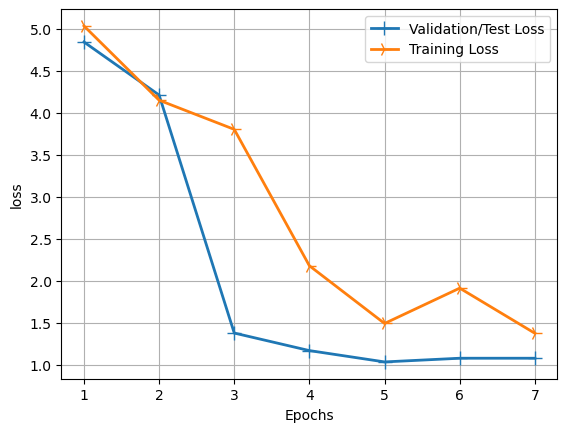

In [48]:
plot_accuracy_loss(history_dense, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

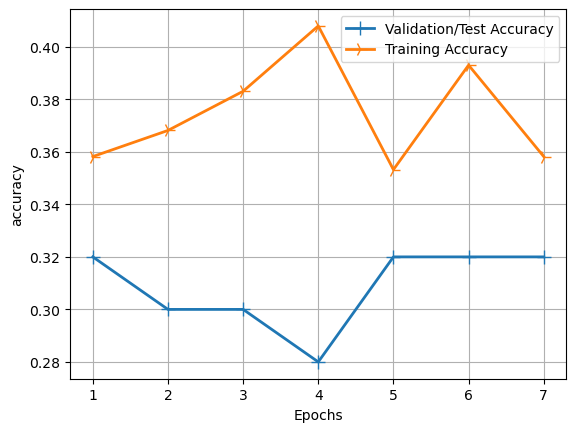

In [49]:
plot_accuracy_loss(history_dense, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Changing Batch Size, Epoch, Optimizer, Learning Rate

In [50]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=7,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [51]:
# Train Dense Model
epochs = 15

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
dense_model_add.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_dense = dense_model_add.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
29/29 [==============================] - 4s 53ms/step - loss: 1.4038 - accuracy: 0.2985 - val_loss: 1.2889 - val_accuracy: 0.4400
Epoch 2/15
29/29 [==============================] - 1s 25ms/step - loss: 1.1674 - accuracy: 0.3930 - val_loss: 1.0986 - val_accuracy: 0.5400
Epoch 3/15
29/29 [==============================] - 1s 25ms/step - loss: 0.9838 - accuracy: 0.4478 - val_loss: 1.0547 - val_accuracy: 0.5400
Epoch 4/15
29/29 [==============================] - 1s 24ms/step - loss: 1.0825 - accuracy: 0.3980 - val_loss: 1.0986 - val_accuracy: 0.4800
Epoch 5/15
29/29 [==============================] - 1s 27ms/step - loss: 1.0549 - accuracy: 0.3532 - val_loss: 1.0986 - val_accuracy: 0.4600


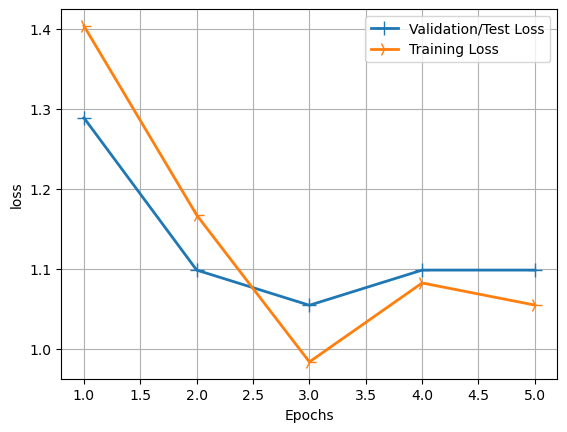

In [52]:
plot_accuracy_loss(history_dense, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

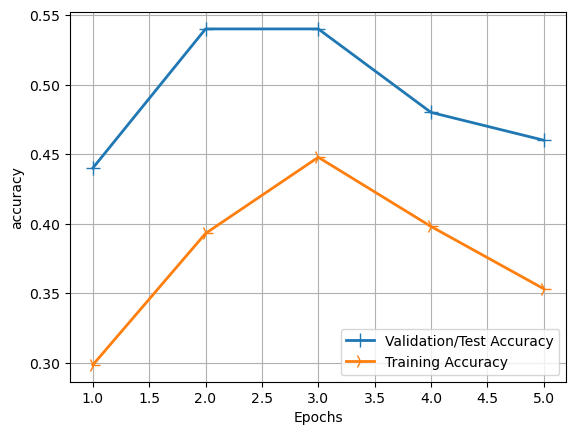

In [53]:
plot_accuracy_loss(history_dense, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Grayscale DenseNet121

The pretrained model is trained on RGB pictures and cannot be applied to greyscale images

### Compare models on Test Data

#### CNN Model Evaluation (No Transfer Learning)¶

In [54]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=(48,48),
)

Found 66 files belonging to 3 classes.


In [55]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 10ms/step - loss: 1.8801 - accuracy: 0.4848


[1.8800700902938843, 0.4848484992980957]

#### MRI Model Evaluation (No Transfer Learning)

In [56]:
model_mri.evaluate(test_ds)

3/3 [==============================] - 0s 15ms/step - loss: 0.1325 - accuracy: 0.9545


[0.13253924250602722, 0.9545454382896423]

#### Mobile Net Transfer Learning Model Evaluation

In [57]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
     color_mode='rgb',
    image_size=(224,224),
)

Found 66 files belonging to 3 classes.


In [58]:
mobile_model_rgb_1.evaluate(test_ds)

3/3 [==============================] - 0s 17ms/step - loss: 0.9855 - accuracy: 0.6667


[0.9855157136917114, 0.6666666865348816]

#### DenseNet121 Transfer Learning Model Evaluation

In [59]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=(224,224),
)

Found 66 files belonging to 3 classes.


In [60]:
dense_model_add.evaluate(test_ds)

3/3 [==============================] - 0s 65ms/step - loss: 1.0653 - accuracy: 0.4394


[1.0653212070465088, 0.43939393758773804]

### Final Step

Overall the model which performed the best on the test data was the mri_model, so we would select this model